# Otimização de hiperparâmetros
### Base de dados de carros vendidos
Cada linha dos dados representa um veículo à venda em um site fictício de vendas de automóveis. A primeira coluna representa o preço de cada veículo; a segunda, se ele foi vendido ou não; a terceira, quantos anos esse modelo tem; e a última, a média de KM esse carro rodou por ano.

Para instalação do graphviz clique [aqui](https://graphviz.org/download/)

In [1]:
import pandas as pd
import numpy as np

from scipy.stats import randint

from sklearn.model_selection import cross_validate
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler

from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import export_graphviz
from sklearn.svm import SVC

import graphviz

In [2]:
# Configuração do pandas para apresentar no máximo 15 linhas de um dataframe
pd.set_option('display.max_rows',15)

# Configuração do pandas para apresentar no máximo 15 colunas de um dataframe
pd.set_option('display.max_columns',15)

In [3]:
uri = "https://gist.githubusercontent.com/guilhermesilveira/e99a526b2e7ccc6c3b70f53db43a87d2/raw/1605fc74aa778066bf2e6695e24d53cf65f2f447/machine-learning-carros-simulacao.csv"

df_veiculos = pd.read_csv(uri, index_col='Unnamed: 0', header=0)

df_veiculos.head()

,preco,vendido,idade_do_modelo,km_por_ano
0,30941.02,1,18,35085.22134
1,40557.96,1,20,12622.05362
2,89627.50,0,12,11440.79806
3,95276.14,0,3,43167.32682
4,117384.68,1,4,12770.11290


In [4]:
X = df_veiculos[['preco', 'idade_do_modelo', 'km_por_ano']]
y = df_veiculos.vendido

### Avaliando uma taxa de acerto aceitável

In [5]:
df_veiculos.vendido.value_counts(normalize=True)*100 

1    58.0
0    42.0
Name: vendido, dtype: float64

Avaliação com Cross Validate e Dummyclassifier:</br>
1- divide a base de dados de forma determinística, sem aleatoriedade;</br>
2- modelo Dummyclassifier com estratégia 'stratifield' - chutar proporcionalmente.</br></br>
<img src='https://scikit-learn.org/stable/_images/grid_search_cross_validation.png' alt="Como funciona o cross validate" width="600" height="350"> </img>
</br>

In [6]:
SEED = 158020
np.random.seed(SEED)

dummy_stratified = DummyClassifier(strategy='stratified')

scores = cross_validate(dummy_stratified, X, y, cv=5)

scores

{'fit_time': array([0., 0., 0., 0., 0.]),
 'score_time': array([0.01562166, 0.        , 0.        , 0.        , 0.        ]),
 'test_score': array([0.4975, 0.4995, 0.5135, 0.501 , 0.5115])}

In [7]:
def calcula_intervao_confianca(scores):
    media = scores.mean()
    desvio_padrao = scores.std()
    intervalo_confiança = ((media-2*desvio_padrao) * 100, (media+2*desvio_padrao) * 100) 

    print(f'A quantidade de splits é de {len(scores)} folds')
    print(f'A média dos scores é de {media:.5f}')
    print(f'O desvio padrão é de {desvio_padrao}')
    print(f'O intervalo de confiança ficou entre {intervalo_confiança[0]:.2f}% e {intervalo_confiança[1]:.2f}%')

In [8]:
calcula_intervao_confianca(scores['test_score'])

A quantidade de splits é de 5 folds
A média dos scores é de 0.50460
O desvio padrão é de 0.006575712889109417
O intervalo de confiança ficou entre 49.14% e 51.78%


Avaliação com Cross Validate e DecisionTreeClassifier:</br>

In [9]:
np.random.seed(SEED)

tree_classifier = DecisionTreeClassifier(max_depth=2)

scores = cross_validate(tree_classifier, X, y, cv=5)

scores

{'fit_time': array([0.01565766, 0.0155921 , 0.        , 0.01563907, 0.01561761]),
 'score_time': array([0., 0., 0., 0., 0.]),
 'test_score': array([0.756 , 0.7565, 0.7625, 0.7545, 0.7595])}

In [10]:
calcula_intervao_confianca(scores['test_score'])

A quantidade de splits é de 5 folds
A média dos scores é de 0.75780
O desvio padrão é de 0.0028565713714171354
O intervalo de confiança ficou entre 75.21% e 76.35%


Avaliação com GroupKFold e DecisionTreeClassifier:</br></br>
É muito importante pensar qual tipo de teste e treino será utilizado, pois se escolhermos um tipo inapropriado, obteremos uma estimativa irreal de como esse estimador funcionará no mundo real.</br>
Precisamos avaliar o modelo para novos carros, o GroupKfold permite fazer o cross validate sem embaralhamento, agrupando por atributo informado.

In [11]:
# Criando a coluna modelo_aleatório - somando um valor randomico entre 1 e 4 a coluna idade_do_modelo
# Isso é, cada ano possui 4 modelos de veículo
# Apesar do modelo_aleatorio ser um número, nesse caso é uma vaiável categórica
df_veiculos_grupo = df_veiculos.copy()

df_veiculos_grupo['modelo_aleatorio'] = np.random.randint(1, 5, size=df_veiculos_grupo.shape[0]) + df_veiculos_grupo.idade_do_modelo
df_veiculos_grupo['modelo_aleatorio'] = df_veiculos_grupo['modelo_aleatorio'].astype("category")

# Exemplo dos 4 modelos para os carros com 10 anos
df_veiculos_grupo.query('idade_do_modelo == 10')['modelo_aleatorio'].unique()

[12, 13, 11, 14]
Categories (23, int64): [2, 3, 4, 5, ..., 21, 22, 23, 24]

In [12]:
df_veiculos_grupo.head(3)

,preco,vendido,idade_do_modelo,km_por_ano,modelo_aleatorio
0,30941.02,1,18,35085.22134,19
1,40557.96,1,20,12622.05362,24
2,89627.50,0,12,11440.79806,14


In [13]:
cv = GroupKFold(n_splits=5)
scores = cross_validate(tree_classifier, X, y, cv=cv, groups=df_veiculos_grupo['modelo_aleatorio'])

scores

{'fit_time': array([0.01563191, 0.01255941, 0.        , 0.01562572, 0.01562262]),
 'score_time': array([0.        , 0.00208998, 0.        , 0.        , 0.        ]),
 'test_score': array([0.75922233, 0.76068376, 0.74937469, 0.73880221, 0.78058445])}

In [14]:
calcula_intervao_confianca(scores['test_score'])

A quantidade de splits é de 5 folds
A média dos scores é de 0.75773
O desvio padrão é de 0.013866144370024005
O intervalo de confiança ficou entre 73.00% e 78.55%


Verificação GroupKFold com SVC

In [15]:
scaler = StandardScaler()
scaler.fit(X)

X_scaler = scaler.transform(X)

In [16]:
np.random.seed(SEED)
svc = SVC()

cv = GroupKFold(n_splits=5)
scores = cross_validate(svc, X_scaler, y, cv=cv, groups=df_veiculos_grupo['modelo_aleatorio'])

scores

{'fit_time': array([2.03163671, 1.87230611, 1.7031014 , 1.68754292, 1.78979158]),
 'score_time': array([1.00002623, 0.84377313, 0.84374404, 0.84370613, 1.07812691]),
 'test_score': array([0.75872383, 0.77526395, 0.75587794, 0.7705083 , 0.78008915])}

In [17]:
calcula_intervao_confianca(scores['test_score'])

A quantidade de splits é de 5 folds
A média dos scores é de 0.76809
O desvio padrão é de 0.009361121937234759
O intervalo de confiança ficou entre 74.94% e 78.68%


### Seguimos com da DecisionTreeClassifier

In [18]:
pd.DataFrame(tree_classifier.get_params(), index=['Params']).T

,Params
ccp_alpha,0.0
class_weight,None
criterion,gini
max_depth,2
max_features,None
max_leaf_nodes,None
min_impurity_decrease,0.0
min_samples_leaf,1
min_samples_split,2
min_weight_fraction_leaf,0.0


Visualização da árvore treinada</br></br>
Agora que temos uma estimativa da acurácia, vamos treinar a árvore de decisão com toda a base de veículos

In [19]:
tree_classifier.fit(X, y)

DecisionTreeClassifier(max_depth=2)

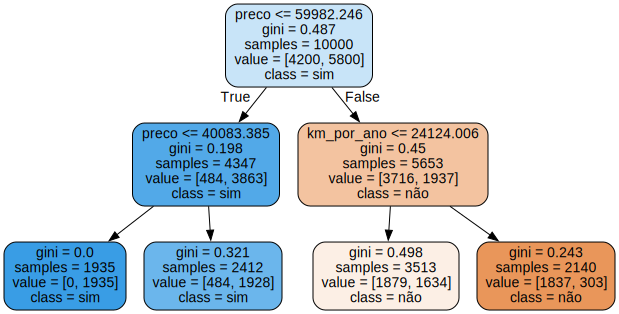

In [20]:
# out_file=None - sem arquivo de saída
# filled=True - preecher os retângulos
# rounded=True - redondos
# class_names=["não", "sim"] - nomes das classes não vendido, sim vendido
# feature_names=features - nomes das colunas de X

def visualizar_arvore(tree_classifier):
    features = X.columns
    dot_data = export_graphviz(tree_classifier, out_file=None, filled=True, rounded=True, class_names=["não", "sim"], feature_names=features)

    graph = graphviz.Source(dot_data)
    return graph

graph = visualizar_arvore(tree_classifier)
graph

Como seria nossa árvore com profundidade 3

In [21]:
np.random.seed(SEED)

tree_classifier = DecisionTreeClassifier(max_depth=3)

scores = cross_validate(tree_classifier, X, y, cv=5)

calcula_intervao_confianca(scores['test_score'])

A quantidade de splits é de 5 folds
A média dos scores é de 0.78690
O desvio padrão é de 0.004532107677449854
O intervalo de confiança ficou entre 77.78% e 79.60%


In [22]:
cv = GroupKFold(n_splits=5)
scores = cross_validate(tree_classifier, X, y, cv=cv, groups=df_veiculos_grupo['modelo_aleatorio'])

calcula_intervao_confianca(scores['test_score'])

A quantidade de splits é de 5 folds
A média dos scores é de 0.78687
O desvio padrão é de 0.00903734608101342
O intervalo de confiança ficou entre 76.88% e 80.49%


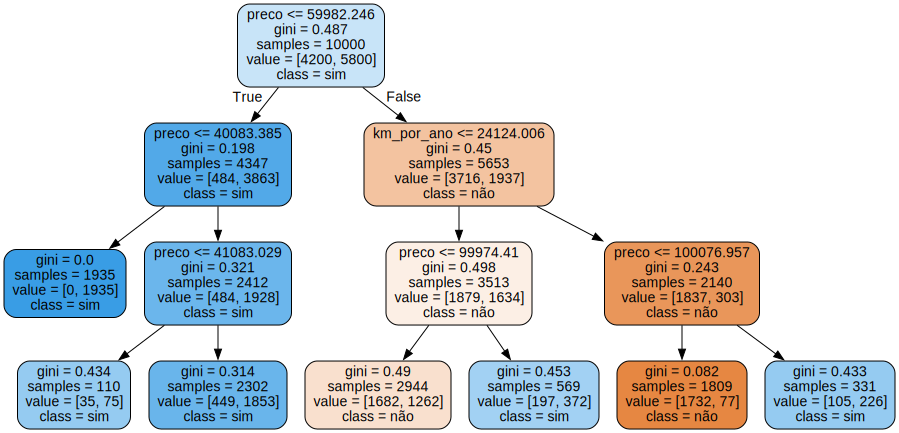

In [23]:
tree_classifier.fit(X, y)

graph = visualizar_arvore(tree_classifier)
graph

### Explorando Espaço de Hiper Parâmetros com GreadSearchCV

In [24]:
np.random.seed(SEED)

# Hiper parâmetros da DecisionTreeClassifier (3 * 3 * 3 * 3 = 243 combinações)
# max_deth - profundidade máxima
# min_samples_split - O número mínimo de amostras necessárias para dividir um nó interno
# min_samples_leaf - O número mínimo de amostras que devem estar em um nó folha.
# criterion - A função para medir a qualidade de uma divisão. 
espaco_de_parametros = {
    "max_depth": [3, 4, 5],
    "min_samples_split": [32, 64, 128],
    "min_samples_leaf": [32, 64, 128],
    "criterion": ['gini', 'entropy', 'log_loss']
}

clf_gridcv  = GridSearchCV(DecisionTreeClassifier(), espaco_de_parametros, cv=GroupKFold(n_splits=10))

clf_gridcv.fit(X, y, groups=df_veiculos_grupo['modelo_aleatorio'])

df_resultados = pd.DataFrame(clf_gridcv.cv_results_)

In [25]:
# melhores parâmetros
clf_gridcv.best_params_

{'criterion': 'gini',
 'max_depth': 3,
 'min_samples_leaf': 32,
 'min_samples_split': 32}

In [26]:
# melhor score
clf_gridcv.best_score_ * 100

78.69859849511785

In [27]:
# melhor modelo
clf_gridcv.best_estimator_

DecisionTreeClassifier(max_depth=3, min_samples_leaf=32, min_samples_split=32)

In [28]:
df_resultados.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_min_samples_leaf,...,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.015625,0.000005,0.001563,0.004689,gini,3,32,...,0.773509,0.769784,0.761321,0.801005,0.786986,0.018282,1
1,0.010936,0.007160,0.001562,0.004687,gini,3,32,...,0.773509,0.769784,0.761321,0.801005,0.786986,0.018282,1
2,0.010942,0.007163,0.001563,0.004688,gini,3,32,...,0.773509,0.769784,0.761321,0.801005,0.786986,0.018282,1
3,0.009369,0.007650,0.004689,0.007162,gini,3,64,...,0.773509,0.769784,0.761321,0.801005,0.786986,0.018282,1
4,0.012498,0.006249,0.000000,0.000000,gini,3,64,...,0.773509,0.769784,0.761321,0.801005,0.786986,0.018282,1


Após encontrar o melhor modelo é recomendado fazer um novo cross validation (nested cross validation), para evitar o uso de um modelo muito otimista.

In [29]:
# infelizmente o cross_val_score ainda não aceita o GroupKFold, erro qual o group informado
# scores = cross_val_score(clf_gridcv, X, y, cv=GroupKFold(n_splits=10), groups=df_veiculos_grupo['modelo_aleatorio'])

In [30]:
# Geramos um novo modelo de GridSeachCV utilizando o KFold com shuffle = True
clf_gridcv  = GridSearchCV(DecisionTreeClassifier(), espaco_de_parametros, cv=KFold(n_splits=10, shuffle=True))

clf_gridcv.fit(X, y)

df_resultados = pd.DataFrame(clf_gridcv.cv_results_)

In [31]:
scores = cross_val_score(clf_gridcv.best_estimator_, X, y, cv=KFold(n_splits=10))

In [32]:
calcula_intervao_confianca(scores)

A quantidade de splits é de 10 folds
A média dos scores é de 0.78690
O desvio padrão é de 0.01041585330157833
O intervalo de confiança ficou entre 76.61% e 80.77%


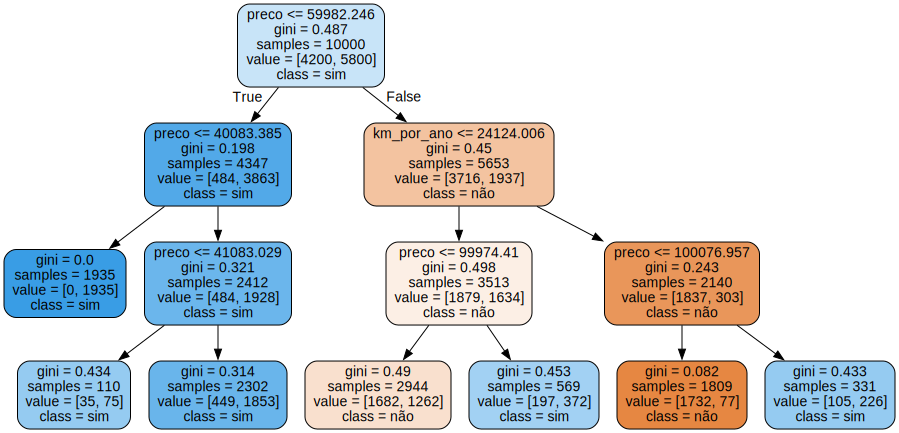

In [33]:
graph = visualizar_arvore(clf_gridcv.best_estimator_)
graph

# Parte II

### Busca aleatória com RandomSearch

In [34]:
# lembrando do espaço de hiperparâmetros
espaco_de_parametros

{'max_depth': [3, 4, 5],
 'min_samples_split': [32, 64, 128],
 'min_samples_leaf': [32, 64, 128],
 'criterion': ['gini', 'entropy', 'log_loss']}

In [35]:
clf_random_search_cv  = RandomizedSearchCV(DecisionTreeClassifier(), espaco_de_parametros, n_iter=16, cv=GroupKFold(n_splits=10), random_state=SEED)

clf_random_search_cv.fit(X, y, groups=df_veiculos_grupo['modelo_aleatorio'])

df_resultados = pd.DataFrame(clf_random_search_cv.cv_results_)

In [36]:
# melhores parâmetros
clf_random_search_cv.best_params_

{'min_samples_split': 128,
 'min_samples_leaf': 32,
 'max_depth': 3,
 'criterion': 'entropy'}

In [37]:
# melhor score
clf_random_search_cv.best_score_ * 100

78.69859849511785

In [38]:
# melhor modelo
clf_random_search_cv.best_estimator_

DecisionTreeClassifier(criterion='entropy', max_depth=3, min_samples_leaf=32,
                       min_samples_split=128)

In [39]:
df_resultados.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_min_samples_split,param_min_samples_leaf,param_max_depth,...,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.016787,0.003485,0.000309,0.000927,128,32,3,...,0.773509,0.769784,0.761321,0.801005,0.786986,0.018282,1
1,0.017187,0.004686,0.003127,0.006254,32,128,4,...,0.773509,0.769784,0.761321,0.801005,0.786986,0.018282,1
2,0.021873,0.007650,0.000000,0.000000,128,128,5,...,0.773509,0.769784,0.761321,0.801005,0.785491,0.016892,15
3,0.015625,0.000001,0.000000,0.000000,64,64,3,...,0.773509,0.769784,0.761321,0.801005,0.786986,0.018282,1
4,0.015628,0.000021,0.000000,0.000000,64,128,4,...,0.773509,0.769784,0.761321,0.801005,0.786986,0.018282,1


Após encontrar o melhor modelo é recomendado fazer um novo cross validation (nested cross validation), para evitar o uso de um modelo muito otimista.

In [40]:
scores = cross_val_score(clf_random_search_cv.best_estimator_, X, y, cv=KFold(n_splits=10))
calcula_intervao_confianca(scores)

A quantidade de splits é de 10 folds
A média dos scores é de 0.78690
O desvio padrão é de 0.01041585330157833
O intervalo de confiança ficou entre 76.61% e 80.77%


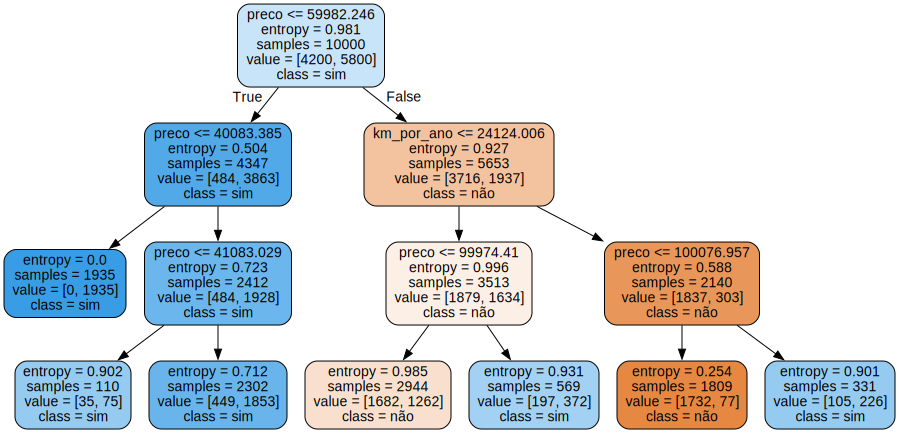

In [41]:
graph = visualizar_arvore(clf_random_search_cv.best_estimator_)
graph

### Customizando o espaço de parâmetros

In [42]:
# Hiper parâmetros da DecisionTreeClassifier (3 * 3 * 3 * 3 = 243 combinações)
# max_deth - profundidade máxima
# min_samples_split - O número mínimo de amostras necessárias para dividir um nó interno
# min_samples_leaf - O número mínimo de amostras que devem estar em um nó folha.
# criterion - A função para medir a qualidade de uma divisão. 
espaco_de_parametros = {
    "max_depth": [3, 5, 10, 15, 20, 30, None],              # testando outras profundidades
    "min_samples_split": randint(32, 128),                  # função que retorna valores inteiros aleatórios
    "min_samples_leaf": randint(32, 128),
    "criterion": ['gini', 'entropy', 'log_loss']
}


# Todas as combinação de parâmetros é calculada assim:
# 7 * 96 * 96 * 3 = 193.536 combinações possíveis

In [43]:
clf_random_search_cv  = RandomizedSearchCV(DecisionTreeClassifier(), espaco_de_parametros, n_iter=16, cv=GroupKFold(n_splits=10), random_state=SEED)

clf_random_search_cv.fit(X, y, groups=df_veiculos_grupo['modelo_aleatorio'])

df_resultados = pd.DataFrame(clf_random_search_cv.cv_results_)

In [44]:
scores = cross_val_score(clf_random_search_cv.best_estimator_, X, y, cv=KFold(n_splits=10))
calcula_intervao_confianca(scores)

A quantidade de splits é de 10 folds
A média dos scores é de 0.78690
O desvio padrão é de 0.01041585330157833
O intervalo de confiança ficou entre 76.61% e 80.77%


Imprimir os resultados do cross validate

In [45]:
for indice, linha in df_resultados[['mean_test_score', 'std_test_score', 'params']].sort_values("mean_test_score", ascending=False).iterrows():
    print(f'Média {linha.mean_test_score:.4f} - Desvio padrão {linha.std_test_score:.4f} - Parâmetros {linha.params}')

Média 0.7870 - Desvio padrão 0.0183 - Parâmetros {'criterion': 'log_loss', 'max_depth': 3, 'min_samples_leaf': 73, 'min_samples_split': 76}
Média 0.7870 - Desvio padrão 0.0183 - Parâmetros {'criterion': 'log_loss', 'max_depth': 3, 'min_samples_leaf': 62, 'min_samples_split': 44}
Média 0.7864 - Desvio padrão 0.0192 - Parâmetros {'criterion': 'log_loss', 'max_depth': None, 'min_samples_leaf': 109, 'min_samples_split': 37}
Média 0.7860 - Desvio padrão 0.0197 - Parâmetros {'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 105, 'min_samples_split': 99}
Média 0.7860 - Desvio padrão 0.0178 - Parâmetros {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 102, 'min_samples_split': 82}
Média 0.7858 - Desvio padrão 0.0192 - Parâmetros {'criterion': 'entropy', 'max_depth': 20, 'min_samples_leaf': 110, 'min_samples_split': 85}
Média 0.7855 - Desvio padrão 0.0169 - Parâmetros {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 114, 'min_samples_split': 122}
Média 0.7836 - Desvi

### Comparando GridSearchCV com o RandomizedSearchCV
Com o GridSearchCV teremos certeza de qual o modelo terá a melhor acurácia, mas com o RandomizedSearchCV teremos controle sobre o custo de processamento e tempo.</br>
Agora vamos utilizar o RandomFlorestClassifier

In [46]:
# Hiper parâmetros da DecisionTreeClassifier (3 * 3 * 3 * 3 = 243 combinações)
# max_deth - profundidade máxima
# min_samples_split - O número mínimo de amostras necessárias para dividir um nó interno
# min_samples_leaf - O número mínimo de amostras que devem estar em um nó folha.
# criterion - A função para medir a qualidade de uma divisão. 
# n_estimators - Número de arvores de decisão que serão criadas
# bootstrap - o treinamento do modelo será feito com parte dos dados, evita overfitting
espaco_de_parametros = {
    "max_depth": [3, 5, 10],                     
    "min_samples_split": [32, 64, 128],          
    "min_samples_leaf": [32, 64, 128],
    "criterion": ['gini', 'entropy', 'log_loss'],
    "n_estimators": [10, 100],
    "bootstrap": [True, False]
}


# Todas as combinação de parâmetros é calculada assim:
# 3 * 3 * 3 * 3 * 2 * 2 = 324 combinações possíveis

RandomForestClassifier com  GridSearchCV</br>
obs- a execução da próxima celula demora em média 30 minutos

In [47]:
clf_gridcv  = GridSearchCV(RandomForestClassifier(), espaco_de_parametros, cv=KFold(n_splits=10, shuffle=True))

clf_gridcv.fit(X, y)

df_resultados = pd.DataFrame(clf_gridcv.cv_results_)

In [48]:
for indice, linha in df_resultados[['mean_test_score', 'std_test_score', 'params']].sort_values("mean_test_score", ascending=False).iterrows():
    print(f'Média {linha.mean_test_score:.4f} - Desvio padrão {linha.std_test_score:.4f} - Parâmetros {linha.params}')

Média 0.7846 - Desvio padrão 0.0130 - Parâmetros {'bootstrap': False, 'criterion': 'log_loss', 'max_depth': 10, 'min_samples_leaf': 32, 'min_samples_split': 128, 'n_estimators': 100}
Média 0.7843 - Desvio padrão 0.0083 - Parâmetros {'bootstrap': True, 'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 32, 'min_samples_split': 128, 'n_estimators': 100}
Média 0.7840 - Desvio padrão 0.0118 - Parâmetros {'bootstrap': False, 'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 32, 'min_samples_split': 128, 'n_estimators': 100}
Média 0.7837 - Desvio padrão 0.0141 - Parâmetros {'bootstrap': False, 'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 64, 'min_samples_split': 128, 'n_estimators': 100}
Média 0.7836 - Desvio padrão 0.0125 - Parâmetros {'bootstrap': False, 'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 64, 'min_samples_split': 64, 'n_estimators': 100}
Média 0.7836 - Desvio padrão 0.0107 - Parâmetros {'bootstrap': True, 'criterion': 'gini', 'max

In [49]:
scores = cross_val_score(clf_gridcv.best_estimator_, X, y, cv=KFold(n_splits=10, shuffle=True))

calcula_intervao_confianca(scores)

A quantidade de splits é de 10 folds
A média dos scores é de 0.78210
O desvio padrão é de 0.012809761902549175
O intervalo de confiança ficou entre 75.65% e 80.77%


RandomForestClassifier com  RandomizedSearchCV

In [50]:
clf_random_search_cv  = RandomizedSearchCV(RandomForestClassifier(), espaco_de_parametros, n_iter= 60, cv=KFold(n_splits=10, shuffle=True))

clf_random_search_cv.fit(X, y)

df_resultados = pd.DataFrame(clf_random_search_cv.cv_results_)

In [51]:
for indice, linha in df_resultados[['mean_test_score', 'std_test_score', 'params']].sort_values("mean_test_score", ascending=False).iterrows():
    print(f'Média {linha.mean_test_score:.4f} - Desvio padrão {linha.std_test_score:.4f} - Parâmetros {linha.params}')

Média 0.7820 - Desvio padrão 0.0174 - Parâmetros {'n_estimators': 100, 'min_samples_split': 128, 'min_samples_leaf': 32, 'max_depth': 10, 'criterion': 'gini', 'bootstrap': True}
Média 0.7812 - Desvio padrão 0.0160 - Parâmetros {'n_estimators': 100, 'min_samples_split': 64, 'min_samples_leaf': 32, 'max_depth': 10, 'criterion': 'log_loss', 'bootstrap': False}
Média 0.7811 - Desvio padrão 0.0198 - Parâmetros {'n_estimators': 10, 'min_samples_split': 128, 'min_samples_leaf': 32, 'max_depth': 10, 'criterion': 'gini', 'bootstrap': True}
Média 0.7811 - Desvio padrão 0.0170 - Parâmetros {'n_estimators': 100, 'min_samples_split': 64, 'min_samples_leaf': 32, 'max_depth': 10, 'criterion': 'entropy', 'bootstrap': True}
Média 0.7811 - Desvio padrão 0.0176 - Parâmetros {'n_estimators': 100, 'min_samples_split': 64, 'min_samples_leaf': 32, 'max_depth': 10, 'criterion': 'gini', 'bootstrap': True}
Média 0.7802 - Desvio padrão 0.0166 - Parâmetros {'n_estimators': 100, 'min_samples_split': 32, 'min_sampl

In [52]:
scores = cross_val_score(clf_random_search_cv.best_estimator_, X, y, cv=KFold(n_splits=10, shuffle=True))

calcula_intervao_confianca(scores)

A quantidade de splits é de 10 folds
A média dos scores é de 0.78210
O desvio padrão é de 0.010261091559868285
O intervalo de confiança ficou entre 76.16% e 80.26%


### Utilizando outra técnica de divisão dos dados
Caso não seja possível rodar utilizando a técnica kfold, existem outras técnicas além da train_test_split, como a StratifiedShuffleSplit que vai aleatorizar e dividir os dados de forma stratificada.

In [53]:
# divisão dos dados em 60% treino, 20% teste e 20% validação
np.random.seed(SEED)

X_train, X_validacao, y_train, y_validacao = train_test_split(X, y, test_size=0.2, shuffle=True, stratify=y)

print(X_train.shape)
print(X_validacao.shape)
print(y_train.shape)
print(y_validacao.shape)


(8000, 3)
(2000, 3)
(8000,)
(2000,)


In [54]:
# Cálculo do test_size para encontrar 20% dos dados completos dentro dos dados de treino.
2000 / 8000

0.25

In [55]:
clf_random_search_cv  = RandomizedSearchCV(RandomForestClassifier(), espaco_de_parametros, n_iter= 5, cv=StratifiedShuffleSplit(n_splits=1, test_size=0.25, random_state=SEED))

clf_random_search_cv.fit(X_train, y_train)

df_resultados = pd.DataFrame(clf_random_search_cv.cv_results_)

In [56]:
for indice, linha in df_resultados[['mean_test_score', 'std_test_score', 'params']].sort_values("mean_test_score", ascending=False).iterrows():
    print(f'Média {linha.mean_test_score:.4f} - Desvio padrão {linha.std_test_score:.4f} - Parâmetros {linha.params}')

Média 0.7755 - Desvio padrão 0.0000 - Parâmetros {'n_estimators': 100, 'min_samples_split': 64, 'min_samples_leaf': 32, 'max_depth': 10, 'criterion': 'gini', 'bootstrap': False}
Média 0.7745 - Desvio padrão 0.0000 - Parâmetros {'n_estimators': 10, 'min_samples_split': 64, 'min_samples_leaf': 64, 'max_depth': 10, 'criterion': 'log_loss', 'bootstrap': False}
Média 0.7700 - Desvio padrão 0.0000 - Parâmetros {'n_estimators': 100, 'min_samples_split': 32, 'min_samples_leaf': 32, 'max_depth': 3, 'criterion': 'log_loss', 'bootstrap': False}
Média 0.7675 - Desvio padrão 0.0000 - Parâmetros {'n_estimators': 10, 'min_samples_split': 32, 'min_samples_leaf': 64, 'max_depth': 3, 'criterion': 'entropy', 'bootstrap': False}
Média 0.7665 - Desvio padrão 0.0000 - Parâmetros {'n_estimators': 100, 'min_samples_split': 64, 'min_samples_leaf': 128, 'max_depth': 10, 'criterion': 'entropy', 'bootstrap': False}


In [57]:
scores = cross_val_score(clf_random_search_cv.best_estimator_, X_validacao, y_validacao, cv=StratifiedShuffleSplit(n_splits=1, test_size=0.25, random_state=SEED))

calcula_intervao_confianca(scores)

A quantidade de splits é de 1 folds
A média dos scores é de 0.74800
O desvio padrão é de 0.0
O intervalo de confiança ficou entre 74.80% e 74.80%
